### Imports

In [79]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import joblib
import numpy as np
import torch
import os
import random


from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from datasets import load_dataset
from cleanlab import Datalab
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from transformers.models.auto.tokenization_auto import AutoTokenizer
from sklearn.metrics import classification_report, roc_auc_score, f1_score

from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification
from transformers.training_args import TrainingArguments
from transformers import Trainer

### task 1: DATA DOWNLOAD and ploting

In [44]:
dataset = load_dataset("PolyAI/banking77", trust_remote_code=True)
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

In [45]:
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")
print(f"Data types: \n{df_train.dtypes}")

Training data shape: (10003, 2)
Test data shape: (3080, 2)
Data types: 
text     object
label     int64
dtype: object


In [46]:
df_train.head(10)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
5,When did you send me my new card?,11
6,Do you have info about the card on delivery?,11
7,What do I do if I still have not received my n...,11
8,Does the package with my card have tracking?,11
9,I ordered my card but it still isn't here,11


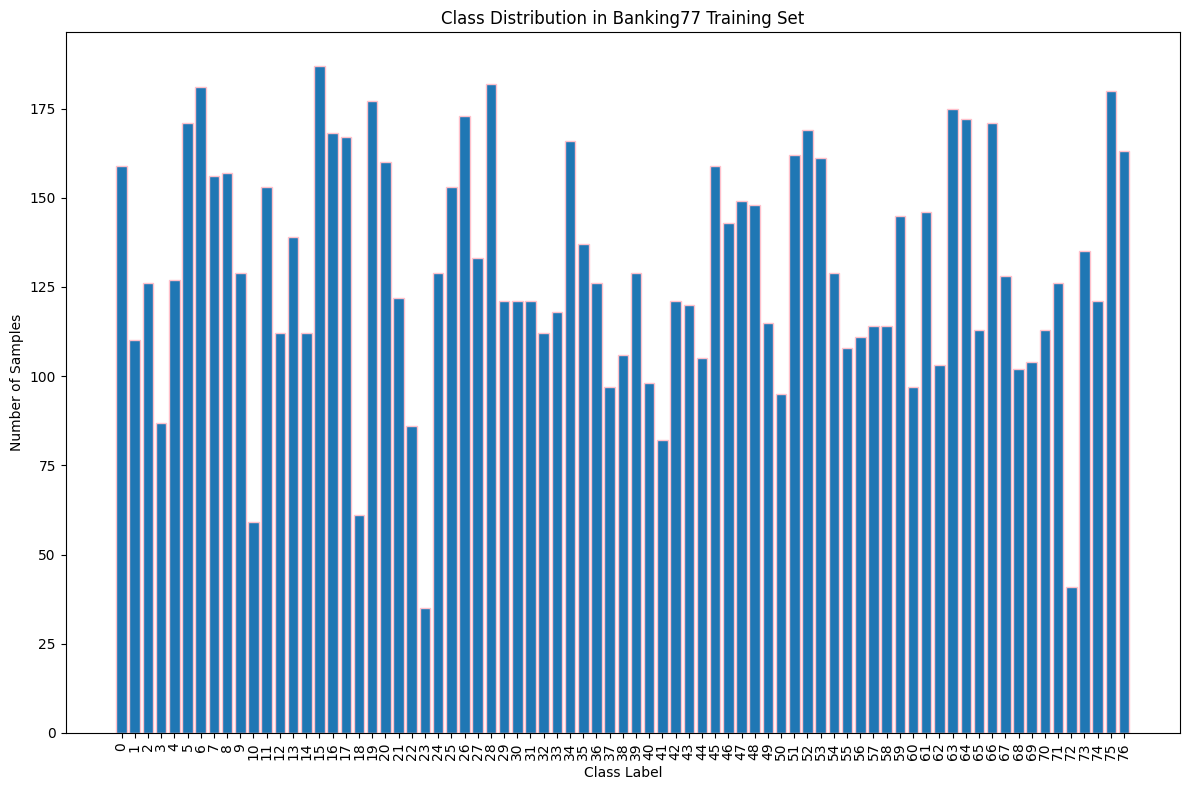

In [47]:
#class distribution


plt.figure(figsize=(12, 8))
class_counts = df_train['label'].value_counts().sort_index()
plt.bar(class_counts.index, class_counts.values,edgecolor='pink')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Banking77 Training Set')
plt.xticks(range(len(class_counts)), rotation=90, fontsize=10) 
plt.tight_layout()
plt.show()

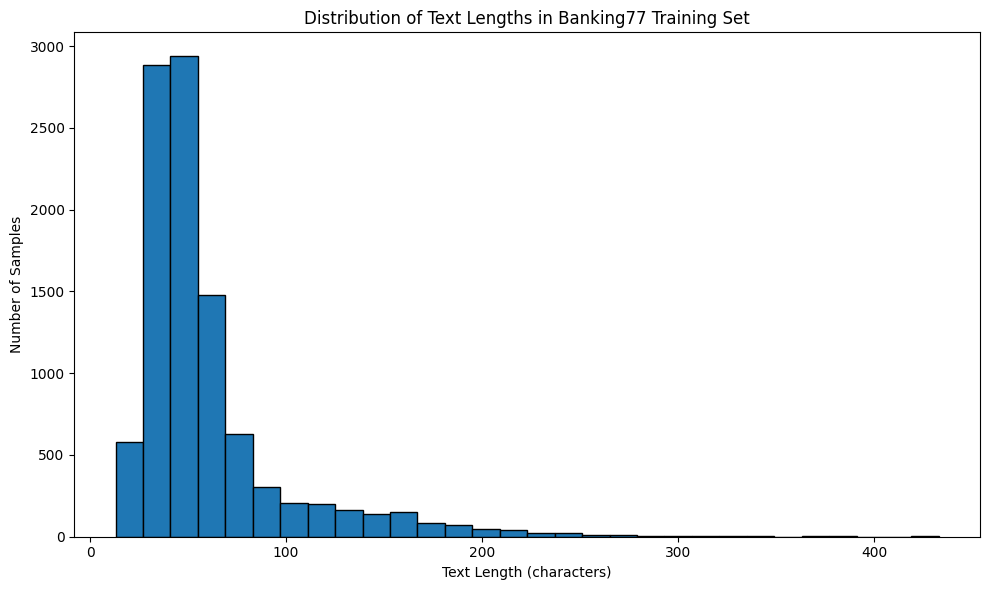

In [48]:
#text length distribution

df_train['text_length'] = df_train['text'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df_train['text_length'], bins=30, edgecolor='black')
plt.xlabel('Text Length (characters)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Text Lengths in Banking77 Training Set')
plt.tight_layout()
plt.show()

### tast 2: Use CleanLab to detect and fix data quality issues

In [49]:
def get_model_data(texts: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(texts)
    classifier = LogisticRegression(max_iter=1000, class_weight="balanced")
    
    pred_probs = cross_val_predict(
        classifier,
        embeddings,
        labels,
        cv=5,
        method="predict_proba"
    )

    return embeddings, pred_probs


In [50]:
text_train = df_train['text'].values
label_train = df_train['label'].values

embeddings_train, pred_probs_train = get_model_data(text_train, label_train)

dict = {
    "texts": text_train,
    "labels": label_train,
    }

clab = Datalab(dict, label_name="labels", task = "classification")
clab.find_issues(pred_probs=pred_probs_train, features=embeddings_train)
clab.report()


Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 648 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         166
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

In [51]:
#analize duplicates

duplicate_issues = clab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

In [52]:
for idx in duplicate_issues.head(10).index:
    row = df_train.iloc[idx]
    print(f"Index: {idx}, label: {row['label']}, text: {row['text']}")

Index: 1710, label: 49, text: 
I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
Index: 1290, label: 14, text: 
I can't seem to be able to use my card



Index: 1246, label: 14, text: I can't seem to be able to use my card
Index: 4594, label: 3, text: Where can I withdraw money from?
Index: 4595, label: 3, text: 
Where can I withdraw money from?
Index: 4903, label: 44, text: How can I reset my passcode?
Index: 4915, label: 44, text: How can i reset my passcode ?
Index: 1724, label: 49, text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
Index: 5922, label: 25, text: Why do you keep declining my payment? I tried several times already with this card and it is just not working.
Index: 5930, label: 25, text: Why do you keep declining my payment?I tried several times already with this card and it is just not working.


In [58]:
# fix issues
label_issues = clab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]].sort_values("label_score")
df_train_fixed = df_train.copy()


if not label_issues.empty:
    idxs = label_issues.index.tolist()
    pred_labels = label_issues["predicted_label"].tolist()
    df_train_fixed.loc[idxs, "label"] = pred_labels
    print(f"Relabeled {len(idxs)} samples")

    
for idx, row in label_issues.head(10).iterrows():
    print(f"Index: {idx}, Given label: {row['given_label']}, Predicted: {row['predicted_label']}, Text: {text_train[idx]}")


Relabeled 166 samples
Index: 1931, Given label: 47, Predicted: 62, Text: i put money on my card and i dont see it on the balance
Index: 4428, Given label: 29, Predicted: 40, Text: i am not a premium customer but i want a virtual card, how do i get it
Index: 4974, Given label: 26, Predicted: 14, Text: Is my card actually working? It's the first time I tried using it
Index: 7583, Given label: 65, Predicted: 62, Text: How do I top up?
Index: 8555, Given label: 59, Predicted: 25, Text: My credit card transaction was declined for a loan payment.  Can you tell me why?
Index: 6033, Given label: 48, Predicted: 5, Text: I have not seen any changes in my account balance(s) after making a transfer.
Index: 1490, Given label: 41, Predicted: 11, Text: Can you tell me the status of my new card?
Index: 6664, Given label: 67, Predicted: 5, Text: I just did a transfer, but don't see the money in my account. What's up?
Index: 5012, Given label: 26, Predicted: 49, Text: my card was frozen due to putting i

In [59]:
duplicate_issues = clab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]].sort_values("near_duplicate_score")

to_drop = set()
for idx, row in duplicate_issues.iterrows():
    group = set([idx] + row["near_duplicate_sets"])
    keep = min(group) 
    to_drop.update(group - {keep})

df_train_fixed = df_train_fixed.drop(index=list(to_drop), errors="ignore")
print(f"Dropped near-duplicates: {len(to_drop)}")

Dropped near-duplicates: 46


In [60]:
outlier_issues = clab.get_issues("outlier")
outlier_issues = outlier_issues[outlier_issues["is_outlier_issue"]].sort_values("outlier_score")
outlier_idxs = outlier_issues.index.tolist()
df_train_fixed = df_train_fixed.drop(index=outlier_idxs, errors="ignore")
print(f"Dropped outliers: {len(outlier_idxs)}")

for idx, row in outlier_issues.head(10).iterrows():
    print(f"Index: {idx}, Text: {text_train[idx]}")


Dropped outliers: 131
Index: 3107, Text: WHAT IS THE ATMOSPHERE OF IT
Index: 4633, Text: what is the word?
Index: 8802, Text: What is this witdrawal
Index: 4655, Text: what is the matter?
Index: 93, Text: WHAT IS THE SOLUTION OF THIS PROBLEM
Index: 4104, Text: I prefer Mastecard.
Index: 7432, Text: I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?
Index: 1311, Text: WHAT IS THE MAIN REASON OF THIS PROBLEM
Index: 1272, Text: WHAT IS THE REASON FOR THAT
Index: 7218, Text: why was i chargged


In [63]:
df_train_clean = df_train_fixed.reset_index(drop=True)
df_train_clean = df_train_clean.drop(columns=["text_length"])
print("Final train shape:", df_train_clean.shape)

Final train shape: (9857, 2)


In [64]:
df_train_clean.head(10)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
5,When did you send me my new card?,11
6,Do you have info about the card on delivery?,11
7,What do I do if I still have not received my n...,11
8,Does the package with my card have tracking?,11
9,I ordered my card but it still isn't here,11


##### do your results agree with the paper pointing out the label quality issues?



nope, i remove 143 lines whats mean ~1,4%, but in the paper they remove 1400 lines.

##### are the problems severe and worth fixing in your opinion?


Yes, according paper, they get 4,5% and 8% increase for the F1-Score and Adjusted Rand Index. So its wort it.

### Task 3: Train a small text classifier

In [70]:
df_train, df_valid = train_test_split(
    df_train_clean,
    test_size=0.2,
    random_state=0,
    stratify=df_train_clean["label"]
)

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(df_test, split="test")

In [71]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_datasets = datasets_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/7885 [00:00<?, ? examples/s]

Map:   0%|          | 0/1972 [00:00<?, ? examples/s]

Map:   0%|          | 0/1971 [00:00<?, ? examples/s]

In [73]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predictions, average="macro")
    return {"f1": f1}

In [78]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

if os.path.exists("./results") and any(f.endswith('.safetensors') for f in os.listdir("./results")):
    print("Model already trained, loading from ./results")
    model = AutoModelForSequenceClassification.from_pretrained("./results")
    trainer.model = model  
else:
    trainer.train()
    trainer.save_model()


Epoch,Training Loss,Validation Loss,F1
1,No log,2.146208,0.647074
2,3.340900,1.021567,0.816551
3,1.613500,0.612117,0.882372
4,0.850300,0.461105,0.902511
5,0.535100,0.422601,0.907824


### task 4: Test the resulting model

In [82]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score
)

predictions = trainer.predict(tokenized_datasets["test"])
logits = predictions.predictions
y_true = predictions.label_ids
y_pred = np.argmax(logits, axis=1)

y_proba = torch.softmax(torch.tensor(logits), dim=1).numpy()

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
auroc_macro_ovo = roc_auc_score(y_true, y_proba, multi_class="ovo", average="macro")


In [83]:
print(f"Accuracy:     {acc:.4f}")
print(f"Precision M:  {prec:.4f}")
print(f"Recall M:     {rec:.4f}")
print(f"F1-score M:   {f1:.4f}")
print(f"AUROC (macro, ovo): {auroc_macro_ovo:.4f}")

Accuracy:     0.9188
Precision M:  0.9253
Recall M:     0.9056
F1-score M:   0.9083
AUROC (macro, ovo): 0.9988


In [84]:
label_names = dataset["train"].features["label"].names

n_classes = len(label_names)
f1_per_class = f1_score(y_true, y_pred, average=None, labels=list(range(n_classes)), zero_division=0)

print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

                                                  precision    recall  f1-score   support

                                activate_my_card       0.97      0.97      0.97        32
                                       age_limit       1.00      0.95      0.98        21
                         apple_pay_or_google_pay       1.00      0.92      0.96        25
                                     atm_support       0.94      1.00      0.97        17
                                automatic_top_up       0.96      0.96      0.96        24
         balance_not_updated_after_bank_transfer       0.80      0.80      0.80        35
balance_not_updated_after_cheque_or_cash_deposit       0.95      1.00      0.97        36
                         beneficiary_not_allowed       0.87      0.90      0.88        29
                                 cancel_transfer       0.97      1.00      0.98        31
                            card_about_to_expire       0.96      1.00      0.98        26
         

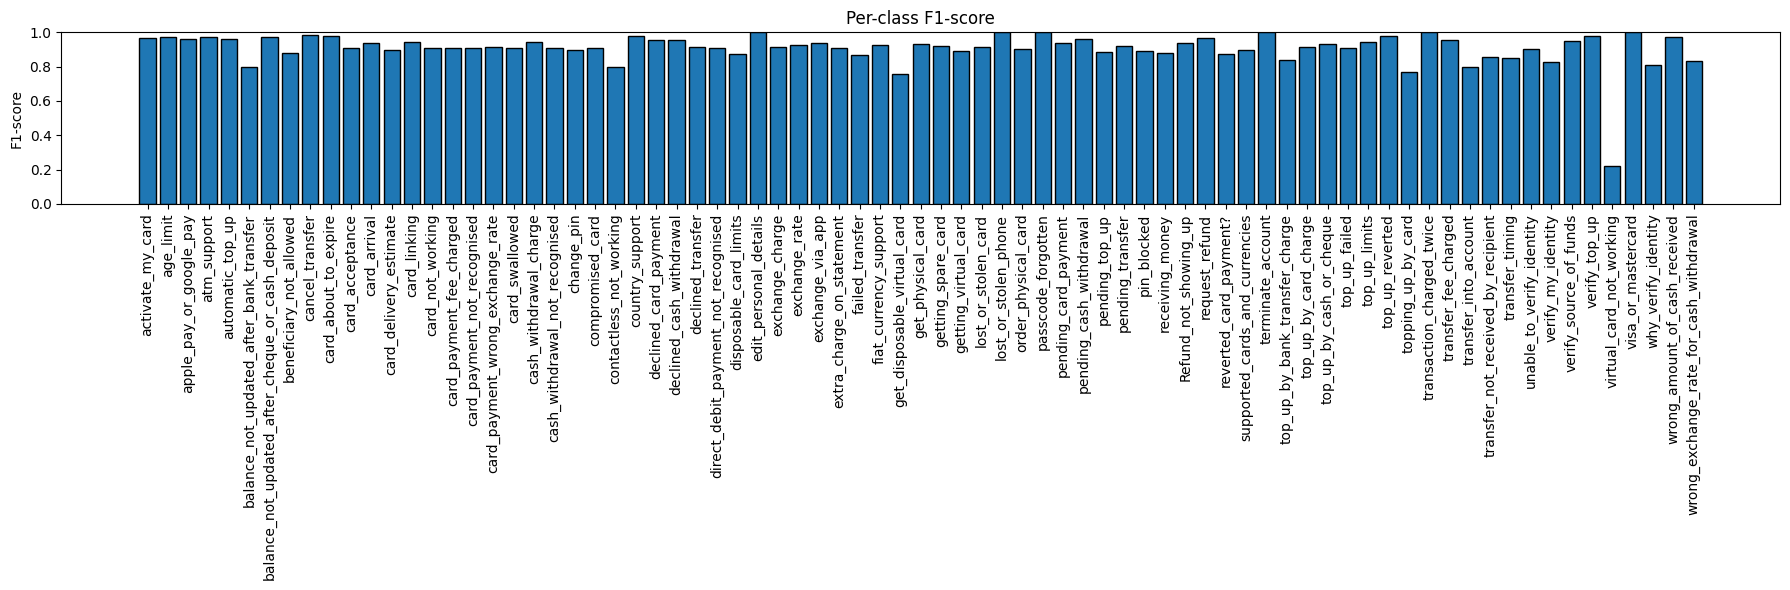

In [87]:
plt.figure(figsize=(18, 6))
bars = plt.bar(range(n_classes), f1_per_class, edgecolor="black")
plt.xticks(range(n_classes), label_names, rotation=90)
plt.ylabel("F1-score")
plt.title("Per-class F1-score")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

Vast majority of classes are pretty close, we have only one class with very low F1 score. For me is high enough.

### Task 5: Use Giskard for behavioral testing

In [88]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan, testing
from transformers import pipeline

model_pipeline = pipeline(
    "text-classification", 
    model=trainer.model, 
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
    top_k= None
)

Device set to use cpu


In [89]:
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    pred_output = model_pipeline(df["text"].tolist())
    prob_arrays = []
    for pred in pred_output:
        probs = [0] * 77
        for item in pred:
            label_idx = int(item["label"].split("_")[-1])
            probs[label_idx] = item["score"]
        prob_arrays.append(probs)
    return np.array(prob_arrays)

In [90]:
giskard_dataset = GiskardDataset(df_test, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=list(range(77)),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

2025-11-23 21:49:37,778 pid:29372 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-23 21:49:37,778 pid:29372 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-23 21:49:37,955 pid:29372 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-23 21:49:38,265 pid:29372 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.406457
2025-11-23 21:49:38,275 pid:29372 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-23 21:49:38,318 pid:29372 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.048799
2025-11-23 21:49:38,324 pid:29372 MainThread giskard.datasets.base 

<iframe id="scan-1537358355792" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:

### Task 6: Use Captum for local explainability

In [91]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis

In [92]:
class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]




In [93]:
def explain_text(model, text: str, y_true: int) -> None:
    for param in model.distilbert.parameters():
        param.requires_grad = True
    
    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=1,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])
    
    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred_proba = softmax(logits, dim=1)[0, 1].item()
        y_pred = int(y_pred_proba >= 0.5)

    attributions = attributions[1:-1]
    tokens = tokens[1:-1]
    
    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=y_pred,
        true_class=y_true,
        attr_class=1,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])


In [94]:
for i in range(5):
    text = df_test.iloc[i]["text"]
    label = df_test.iloc[i]["label"]
    print(f"Explaining sample {i}:")
    explain_text(trainer.model, text, label)

Explaining sample 0:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
9,0 (0.00),1,0.06,"my card ' s ex ##pi ##ring a month from now , should i place an order for the new card ?"


Explaining sample 1:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
24,0 (0.00),1,-0.57,you operate in which countries ?


Explaining sample 2:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
50,0 (0.00),1,-0.23,how can i receive money from someone ?


Explaining sample 3:


Explaining sample 4:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
67,0 (0.00),1,0.33,i need to transfer something to china . it is urgent . how many days will it take to get there ?
